In [9]:
import os

from math import ceil, floor

import copy

import pickle

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets.vision import VisionDataset

from tqdm import tqdm

from datasets import prepare_poison_dataset
from simclr import SimClrBackbone

In [10]:
device = "cuda"

### Load SimCLR model

In [12]:
def load_simclr(simclr_model_name: str) -> SimClrBackbone:
    model = SimClrBackbone()
    out = os.path.join('./saved_models/', simclr_model_name)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(device)
    model.eval()
    return model

### Extract SimCLR features for all images

In [13]:
def extract_simclr_features(model: SimClrBackbone, dataset: VisionDataset):

    simclr_feature_size = 128
    num_examples = len(dataset)

    features = np.zeros((num_examples, simclr_feature_size))
    labels_poison = np.zeros((num_examples))
    labels_true = np.zeros((num_examples))

    batch_size = 256
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        features[i*batch_size : i*batch_size+len(features_batch)] = features_batch
        labels_poison[i*batch_size : i*batch_size+len(labels_batch_poison)] = labels_batch_poison.long()
        labels_true[i*batch_size : i*batch_size+len(labels_batch_true)] = labels_batch_true.long()

    labels_poison = labels_poison.astype(int)
    labels_true = labels_true.astype(int)

    return features, labels_poison, labels_true

### Plot 2-D features

In [44]:
from sklearn.manifold import TSNE
import umap

def calculate_features_2d(features: np.array, n_neighbors: int = 100, algorithm: str = "umap", min_dist: float = 0.1) -> np.array:
    assert algorithm in ["umap", "tsne"]
    
    if algorithm == "umap":
        alg = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
    elif algorithm == "tsne":
        alg = TSNE(n_components = 2, perplexity = n_neighbors)
    features_2d = alg.fit_transform(features)
    return features_2d

def plot_features_2d(features_2d: np.array, labels: np.array, poison_indices: np.array, legend: bool = True) -> None:
    num_classes = int(max(labels).item())

    # label poison examples as 10
    labels_10 = copy.deepcopy(labels)
    labels_10[poison_indices] = 10

    for i in range(num_classes):
        plt.scatter(features_2d[labels_10==i,1], features_2d[labels_10==i,0])
    plt.scatter(features_2d[labels_10==10,1], features_2d[labels_10==10,0], c = "black", marker= "x", s=1)

    if legend:
        plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()


def calculate_and_plot_features_2d(features: np.array, labels: np.array, poison_indices: np.array, subset_size: int = None, legend: bool = True) -> np.array:
    # Plot only a subset
    if subset_size is None:
        subset_size = len(features)
    features_subset = features[:subset_size]
    labels_subset = labels[:subset_size]
    poison_indices_subset = poison_indices[:subset_size]
    
    features_2d = calculate_features_2d(features_subset)
    plot_features_2d(features_2d, labels_subset, poison_indices_subset, legend=legend)
    


### Util functions for all cleanses

In [15]:
def print_evaluate_cleanse(poison_predicted: np.array, poison_indices: np.array, verbose: bool = True) -> float:

    tp = (poison_indices & poison_predicted).sum()
    fp = (np.invert(poison_indices) & poison_predicted).sum()
    fn = (poison_indices & np.invert(poison_predicted)).sum()
    tn = (np.invert(poison_indices) & np.invert(poison_predicted)).sum()

    fnr = fn/(fn+tp) if fn+tp!=0 else 0
    tnr = tn/(tn+fp) if tn+fp!=0 else 0
    poison_rate = fn/(fn+tn) if fn+tn!=0 else 0

    if verbose:
        print(f"{tp} \t {fp}")
        print(f"{fn} \t {tn}")
        print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
        print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
        print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")

def evaluate_cleanse(poison_predicted: np.array, poison_indices: np.array, verbose: bool = True) -> float:

    tp = (poison_indices & poison_predicted).sum()
    fp = (np.invert(poison_indices) & poison_predicted).sum()
    fn = (poison_indices & np.invert(poison_predicted)).sum()
    tn = (np.invert(poison_indices) & np.invert(poison_predicted)).sum()

    fnr = fn/(fn+tp) if fn+tp!=0 else 0
    tnr = tn/(tn+fp) if tn+fp!=0 else 0
    poison_rate = fn/(fn+tn) if fn+tn!=0 else 0

    return poison_rate, fnr, tnr

In [16]:
def save_predicted_indices(predicted_indices: np.array, save_name: str):
    with open(f"./cleansed_labels/{save_name}.pkl", "wb") as f:
        pickle.dump(predicted_indices, f)

In [17]:
def plot_histogram_poisoned(values: np.array, poison_indices: np.array = None, is_integer: bool = False, bins_num: int = 100, separation_line: float = None) -> None:
    if poison_indices is not None:
        values_clean = values[np.invert(poison_indices)]
        values_poisoned = values[poison_indices]
    else:
        values_clean = values[:]
        values_poisoned = []

    bins = np.linspace(floor(np.min(values)), ceil(np.max(values)), int(np.max(values)) if is_integer else bins_num)
    plt.hist(values_clean, bins, alpha=0.5, label='clean')
    plt.hist(values_poisoned, bins, alpha=0.5, label='poisoned')

    if separation_line:
        plt.axvline(separation_line, color='red', linestyle='dashed', linewidth=1)

    plt.legend(loc='upper right')
    plt.show()

## Step 1: Non-disruptive cleanse

### kNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier

def knn_cleanse(features: np.array, labels_poison: np.array, num_classes: int, n_neighbors: int = None) -> np.array:
    
    if n_neighbors is None:
        examples_per_class = len(features) / num_classes
        n_neighbors=int(examples_per_class/2)
        
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(features, labels_poison)
    labels_predicted = knn.predict(features)

    return labels_predicted != labels_poison

### Energy

In [19]:
class EnergyClassifier():

    def __init__(self, t=1):
        self.t = t

    def fit(self, X, y):
        self.X = X
        self.y = y
        
        self.C = int(np.max(y))
        self.Ic = {c:[i for i in range(len(y)) if y[i]==c] for c in range(self.C)}
        
    def predict_index(self, i):
        # consider improving with numpy and batch

        xi = self.X[i]

        exp_all = np.exp([xi*self.X[k]/self.t for k in range(len(self.X))])
        sum_exp_all_except_xi = np.sum([exp_all[k] for k in range(len(self.X)) if k!=i])
        mean_exp_c = [np.mean([exp_all[k] for k in self.Ic[c] if k!=i]) for c in range(self.C)]
    
        Scs = mean_exp_c / sum_exp_all_except_xi
        return np.argmax(Scs)

    def predict(self):
        predicted = np.zeros((len(self.X)))
        for i in tqdm(range(len(self.X))):
            predicted[i] = self.predict_index(i)
        return predicted

In [20]:
def energy_cleanse(features: np.array, labels_poison: np.array, t: float = 10) -> np.array:
    
    # if DATASET == "badnets":
    #     T = 100
    # elif DATASET == "wanet":
    #     T = 10
    # elif DATASET == "sig":
    #     T = 1
    # else:
    #     raise Exception("Invalid dataset")

    energy = EnergyClassifier(t=t)
    energy.fit(features, labels_poison)
    labels_predicted = energy.predict()

    return labels_predicted != labels_poison


## Disruptive detection

### Centroid

In [21]:
def centroid_cleanse(features: np.array, poison_indices: np.array) -> np.array:
    centroid = np.sum(features, axis=0) / features.shape[0]
    distances = np.linalg.norm(features - centroid, axis=1)
    
    plot_histogram_poisoned(distances, poison_indices)

### Gauss 

In [22]:
from scipy.stats import multivariate_normal

def gauss_cleanse(features: np.array, discard_percentage: float, poison_indices: np.array = None) -> np.array:
    mean = np.mean(features, axis=0)
    cov = np.cov(features, rowvar=0)

    probabilities = multivariate_normal.pdf(features, mean=mean, cov=cov, allow_singular=True)
    probabilities[probabilities <= 0] = 1e-100
    probabilities = -np.log(probabilities)

    discard_line = np.percentile(probabilities, (1-discard_percentage)*100)
    plot_histogram_poisoned(probabilities, poison_indices, separation_line=discard_line)

    predicted_poison_indices = probabilities > discard_line
    return predicted_poison_indices

In [23]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

def kmeans_cleanse(features: np.array, means: int = 50) -> np.array:
	kmeans = KMeans(n_clusters=means, init="k-means++")
	kmeans.fit(features)
	
	centroid = np.mean(features, axis=0)
	cluster_center_distances = [euclidean(center, centroid) for center in kmeans.cluster_centers_]
	poison_cluster_index = cluster_center_distances.index(max(cluster_center_distances))

	predicted_poison_indices = kmeans.predict(features) == poison_cluster_index
	return predicted_poison_indices

In [24]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

def kmeans_cleanse(features: np.array, means: int = 50, mode: str = "both") -> np.array:

	assert mode in ["distance", "size", "both"]

	kmeans = KMeans(n_clusters=means, init="k-means++")
	kmeans.fit(features)
	
	if mode == "distance":
		centroid = np.mean(features, axis=0)
		cluster_center_distances = [euclidean(center, centroid) for center in kmeans.cluster_centers_]
		poison_cluster_index = cluster_center_distances.index(max(cluster_center_distances))
	
	elif mode == "size":
		predicted_cluster = kmeans.predict(features)
		_, counts = np.unique(predicted_cluster, return_counts=True)
		poison_cluster_index = np.argmin(counts)
	
	elif mode == "both":
		centroid = np.mean(features, axis=0)
		cluster_center_distances = [euclidean(center, centroid) for center in kmeans.cluster_centers_]
		poison_cluster_index_1 = cluster_center_distances.index(max(cluster_center_distances))

		predicted_cluster = kmeans.predict(features)
		_, counts = np.unique(predicted_cluster, return_counts=True)
		poison_cluster_index_2 = np.argmin(counts)

		if poison_cluster_index_1 != poison_cluster_index_2:
			# No poison detected
			return np.zeros(features.shape)
		else:
			poison_cluster_index = poison_cluster_index_1


	predicted_poison_indices = kmeans.predict(features) == poison_cluster_index
	return predicted_poison_indices

## Poison reclassification

### Weak binary classifier 

In [25]:
class PoisonClassificationDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, poison_indices: np.array) -> None:
        self.original_dataset = original_dataset
        self.poison_indices = poison_indices

    def __len__(self) -> int:
        return len(self.original_dataset)
    
    def __getitem__(self, index: int):
        return self.original_dataset[index][0], torch.tensor(self.poison_indices[index])

In [26]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = F.sigmoid(out)
        return out


def ResNetBinary():
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=1)

In [27]:
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler

class ConvolutionalBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Linear(1568, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x) -> torch.tensor:
        return self.layers(x)

def train_binary_classifier(dataset: VisionDataset, predicted_poison_indices: np.array) -> nn.Module:
    poison_classification_dataset = PoisonClassificationDataset(dataset, predicted_poison_indices)
    # sampler for class imbalance
    positives = sum([1 for _, target in poison_classification_dataset if target==1])
    total = len(poison_classification_dataset)
    positive_weight = 0.5 / positives
    negative_weight = 0.5 / (total - positives)
    weights = [positive_weight if target==1 else negative_weight for _, target in poison_classification_dataset]
    sampler = WeightedRandomSampler(weights, len(weights))

    dataloader = DataLoader(poison_classification_dataset, batch_size=128, sampler=sampler)
    model = ResNetBinary().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1-1e-4)
    num_epochs = 10

    for _ in tqdm(range(num_epochs)):
        for _, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device).float()
            optimizer.zero_grad()
            logits = model.forward(inputs).squeeze(-1)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    return model

def binary_reclassification(dataset: VisionDataset, model: nn.Module):
    predicted_poison_indices = np.zeros((len(dataset)))
    batch_size = 128
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for i, (inputs, _, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        with torch.no_grad():
            logits = model.forward(inputs).squeeze(-1)
            predictions = (logits>0.5).cpu().numpy()
        predicted_poison_indices[i*batch_size : i*batch_size+len(predictions)] = predictions
    return predicted_poison_indices==1
        


### Strong multiclass classifier

In [28]:
from torchvision import transforms

class CleansedDataset(VisionDataset):

    def __init__(self, poison_dataset: VisionDataset, predicted_poison: np.array, transforms: torch.nn.Module = None):
        self.data = [poison_dataset[i][0] for i in range(len(poison_dataset)) if not predicted_poison[i]]
        self.labels = [poison_dataset[i][1] for i in range(len(poison_dataset)) if not predicted_poison[i]]
        self.transforms = transforms

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data[index]
        label = self.labels[index]

        if self.transforms:
            item = self.transforms(item)

        return item, label

In [29]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [30]:
def train_multiclass_classifier(dataset: VisionDataset, predicted_poison_indices: np.array) -> nn.Module:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    cleansed_dataset = CleansedDataset(dataset, predicted_poison_indices, transform_train)
    dataloader = DataLoader(cleansed_dataset, batch_size=128, shuffle=True, num_workers=0)

    model = ResNet18()
    model.to(device)

    epochs = 35
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    model.train()
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        correct = 0
        total = 0
        for _, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        acc = 100.*correct/total
        scheduler.step()
        print(epoch, train_loss, acc)
    model.eval()
    return model

In [31]:
def multiclass_reclassification(dataset: VisionDataset, model: nn.Module, true_labels: np.array):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    transform_dataset = CleansedDataset(dataset, np.zeros(len(dataset)), transform_train)
    
    predicted_labels = np.zeros((len(dataset)))
    batch_size = 128
    dataloader = DataLoader(transform_dataset, batch_size=batch_size, shuffle=False)
    for i, (inputs, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        with torch.no_grad():
            logits = model.forward(inputs)
            predictions = torch.argmax(logits, 1).cpu().numpy()
        predicted_labels[i*batch_size : i*batch_size+len(predictions)] = predictions
    return predicted_labels!=true_labels

# Final cleanse pipeline

In [32]:
device = "cuda"

dataset_name = "wanet"
train = True

simclr_model_name = f"{dataset_name}-SimCLR.pt"

dataset, true_poison_indices, _, _ = prepare_poison_dataset(dataset_name, train)
simclr = load_simclr(simclr_model_name)
features, labels_poison, labels_true = extract_simclr_features(simclr, dataset)
num_classes = int(max(labels_poison).item())

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
# Hiperparameters

n_neighbors = int(len(dataset) / 100)

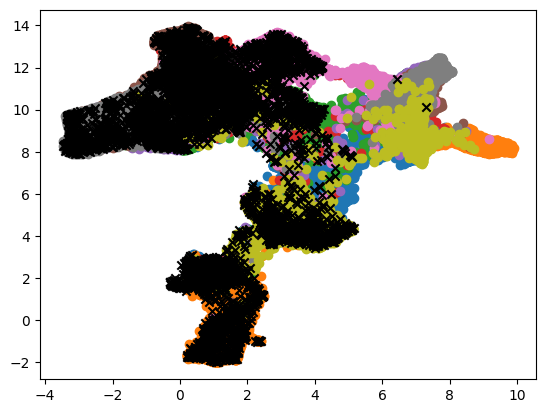

In [43]:
features_2d = calculate_features_2d(features, n_neighbors=n_neighbors)
plot_features_2d(features_2d, labels_poison, true_poison_indices, legend=False)

In [85]:
# TESTING
# count = 0
# total = 50
# for current in range(1,total+1):
#     predicted_poison_indices_disruptive = kmeans_cleanse_smallest(features_2d, means=11)
#     pr = print_evaluate_cleanse(predicted_poison_indices_disruptive, true_poison_indices, verbose=False)
#     if pr==0:
#         count+=1
#     print(f"{pr} - {count}/{current}")

In [35]:
# Nondisruptive cleanse
predicted_poison_indices_nondisruptive = knn_cleanse(features, labels_poison, num_classes, n_neighbors=n_neighbors)
print_evaluate_cleanse(predicted_poison_indices_nondisruptive, true_poison_indices)

4819 	 9694
181 	 35306
Percentage of poisoned images (out of all poisoned) kept:  3.62%
Percentage of clean images (out of all clean) kept:  78.46%
Percentage of remaining poisoned images (out of all remaining):  0.51%


In [87]:
# Disruptive cleanse
#predicted_poison_indices_disruptive = gauss_cleanse(tsne_features, gauss_discard, poison_indices=true_poison_indices)
predicted_poison_indices_disruptive = kmeans_cleanse(features_2d, means=11, mode="both")
print_evaluate_cleanse(predicted_poison_indices_disruptive, true_poison_indices)

410 	 2740
4590 	 42260
Percentage of poisoned images (out of all poisoned) kept:  91.80%
Percentage of clean images (out of all clean) kept:  93.91%
Percentage of remaining poisoned images (out of all remaining):  9.80%


In [88]:
# Combine cleanses

predicted_poison_indices_final = predicted_poison_indices_nondisruptive | predicted_poison_indices_disruptive
print_evaluate_cleanse(predicted_poison_indices_final, true_poison_indices)

4818 	 12507
182 	 32493
Percentage of poisoned images (out of all poisoned) kept:  3.64%
Percentage of clean images (out of all clean) kept:  72.21%
Percentage of remaining poisoned images (out of all remaining):  0.56%


In [115]:
#poison_multiclass_classifier_model = train_multiclass_classifier(dataset, predicted_poison_indices_final)
#poison_multiclass_classifier_model = train_binary_classifier(dataset, predicted_poison_indices_final)

C:\Users\Luka\AppData\Local\Temp\ipykernel_1296\2447615426.py:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return self.original_dataset[index][0], torch.tensor(self.poison_indices[index])
100%|██████████| 10/10 [2:56:48<00:00, 1060.88s/it] 


In [109]:
#predicted_poison_indices_multiclass_reclassification = multiclass_reclassification(dataset, poison_multiclass_classifier_model, labels_poison)
#predicted_poison_indices_multiclass_reclassification = binary_reclassification(dataset, poison_multiclass_classifier_model)
#print_evaluate_cleanse(predicted_poison_indices_multiclass_reclassification, true_poison_indices)

4406 	 22197
594 	 22803
Percentage of poisoned images (out of all poisoned) kept:  11.88%
Percentage of clean images (out of all clean) kept:  50.67%
Percentage of remaining poisoned images (out of all remaining):  2.54%


In [94]:
# Final cleanse report
print("---------------------------------------")
train_string = "train" if train else "test"
print(f"{dataset_name} {train_string}")
print("\nNon-disruptive cleanse: ")
print_evaluate_cleanse(predicted_poison_indices_nondisruptive, true_poison_indices)
print("\nDisruptive cleanse: ")
print_evaluate_cleanse(predicted_poison_indices_disruptive, true_poison_indices)
print("\nCombined cleanse: ")
print_evaluate_cleanse(predicted_poison_indices_final, true_poison_indices)
#print("\nReclassify (multiclass) combined cleanse: ")
#print_evaluate_cleanse(predicted_poison_indices_multiclass_reclassification, true_poison_indices)
print("---------------------------------------")

---------------------------------------
wanet train

Non-disruptive cleanse: 
4816 	 10072
184 	 34928
Percentage of poisoned images (out of all poisoned) kept:  3.68%
Percentage of clean images (out of all clean) kept:  77.62%
Percentage of remaining poisoned images (out of all remaining):  0.52%

Disruptive cleanse: 
410 	 2740
4590 	 42260
Percentage of poisoned images (out of all poisoned) kept:  91.80%
Percentage of clean images (out of all clean) kept:  93.91%
Percentage of remaining poisoned images (out of all remaining):  9.80%

Combined cleanse: 
4818 	 12507
182 	 32493
Percentage of poisoned images (out of all poisoned) kept:  3.64%
Percentage of clean images (out of all clean) kept:  72.21%
Percentage of remaining poisoned images (out of all remaining):  0.56%

Reclassify (multiclass) combined cleanse: 
4382 	 12045
618 	 32955
Percentage of poisoned images (out of all poisoned) kept:  12.36%
Percentage of clean images (out of all clean) kept:  73.23%
Percentage of remainin

In [92]:
train_str = "train" if train else "test"
save_name = f"{dataset_name}-(knn+umap+kmeans)-{train_str}"

#save_predicted_indices(predicted_poison_indices_final, save_name)